# Why matrix inversion doesn't work?
Trying to unfold with a naive matrix inversion approach and with a more educated SVD pseudo-matrix inversion approach

In [2]:
import sys
sys.path
sys.path.append("..")

# numpy imports and settings
import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=500)
# example imports
from examples import example
# plotting imports
import pylab as plt
%matplotlib inline
import root_numpy

def histogram_to_python(hist):
    """
    Converts a ROOT THx to a numpy array.

    Returns: histogram, edges
    """
    return root_numpy.hist2array(hist, return_edges=True)

Welcome to JupyROOT 6.23/01


In [32]:
# define a useful util to plot
def plot_everything(Adetpy, xinipy, binipy, xinipy_edges, reconstructed_name=None):
    # Create figure
    fig = plt.figure(figsize=(15, 7))
    # Show response matrix on the left side
    ax = fig.add_subplot(1, 2, 1)
    left_edge  = xinipy_edges[0][0]
    right_edge = xinipy_edges[0][-1]
    bottom_edge  = binipy_edges[0][-1]
    top_edge = binipy_edges[0][0]
    img = ax.imshow(Adetpy, extent=[left_edge, right_edge, bottom_edge, top_edge])
    ax.set_xlabel("true ($x_{ini}$)")
    ax.set_ylabel("measured ($b_{ini}$)")
    ax.set_title("Response matrix (probab. of event from j migrating to i)")
    fig.colorbar(img)
    # Show the histograms on the right side
    ax = fig.add_subplot(1, 2, 2)
    axis = xinipy_edges[0][:-1]
    ax.step(axis, xinipy, fillstyle="bottom", label="True") # plot x_ini
    ax.fill_between(axis, xinipy, step="pre", alpha=0.4)
    reconstructed_name = "$b_{ini}$" if reconstructed_name is None else reconstructed_name
    ax.step(axis, binipy, fillstyle="bottom", label=reconstructed_name) # plot b_ini
    ax.fill_between(axis, binipy, step="pre", alpha=0.4)
    ax.set_xlabel("x")
    ax.set_ylabel("entries")
    ax.legend()

def plot_for_document(Adetpy, xinipy, binipy, unfoldedpy, xinipy_edges):
    color_true = "#C93312" #red
    color_unfolded = "#899DA4" #gray
    fig = plt.figure(figsize=(30, 7))
    # show original histograms on the left
    ax = fig.add_subplot(1, 3, 1)
    axis = xinipy_edges[0][:-1]
    ax.step(axis, xinipy, color=color_true, fillstyle="bottom", label="True")
    ax.fill_between(axis, xinipy, color=color_true, step="pre", alpha=0.5)
    ax.step(axis, binipy, color=color_unfolded, fillstyle="bottom", label="Measured") 
    ax.fill_between(axis, binipy, color=color_unfolded, step="pre", alpha=0.7)
    ax.set_xlabel("Physical Observable")
    ax.set_ylabel("# of observations")
    ax.legend()
    # show unfolded on the middle
    ax = fig.add_subplot(1,3,2)
    axis = xinipy_edges[0][:-1]
    ax.step(axis, xinipy, color=color_true, fillstyle="bottom", label="True")
    ax.fill_between(axis, xinipy, color=color_true, step="pre", alpha=0.5)
    ax.step(axis, unfoldedpy, color=color_unfolded, fillstyle="bottom", label="Unfolded") 
    ax.fill_between(axis, unfoldedpy, color=color_unfolded, step="pre", alpha=0.7)
    ax.set_xlabel("Physical Observable")
    ax.set_ylabel("# of observations")
    ax.legend()
    # show response matrix on the right
    ax = fig.add_subplot(1, 3, 3)
    left_edge  = xinipy_edges[0][0]
    right_edge = xinipy_edges[0][-1]
    bottom_edge  = binipy_edges[0][-1]
    top_edge = binipy_edges[0][0]
    img = ax.imshow(Adetpy, extent=[left_edge, right_edge, bottom_edge, top_edge])
    ax.set_xlabel("true ($x_{ini}$)")
    ax.set_ylabel("measured ($b_{ini}$)")
    fig.colorbar(img)
    for i in range(len(Adetpy)):
        for j in range(len(Adetpy[i])):
            img.axes.text(j,i, Adetpy[i,j], ha="center", va="center")

##  Data preparation
Initialize data

In [15]:
# toy generation
nbins = 8
# Generate initial distribution and response matrix
xini, bini, Adet = example.maker.generate_initial_samples(nbins)
# Generate test distribution (what is measured in the experiment)
datatrue, data, statcov = example.maker.generate_test_samples(nbins)

# Map ROOT objects to numpy arrays
xinipy, xinipy_edges = histogram_to_python(xini)
binipy, binipy_edges = histogram_to_python(bini)
Adetpy_events, Adetpy_edges = histogram_to_python(Adet)

# Data
datapy, datapy_edges = histogram_to_python(data)
# Data "truth" distribution to test the unfolding
datatruepy, datatruepy_edges = histogram_to_python(datatrue)
# Statistical covariance matrix
statcovpy, statcovpy_edges = histogram_to_python(statcov)
# Turn Adetpy from number of events to probabilities (to use it with quantum annealing)
Adetpy = np.true_divide(Adetpy_events, xinipy, where=xinipy!=0)

Warning in <TROOT::Append>: Replacing existing TH1: xini (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: bini (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Adet (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: datatrue (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: statcov (Potential memory leak).


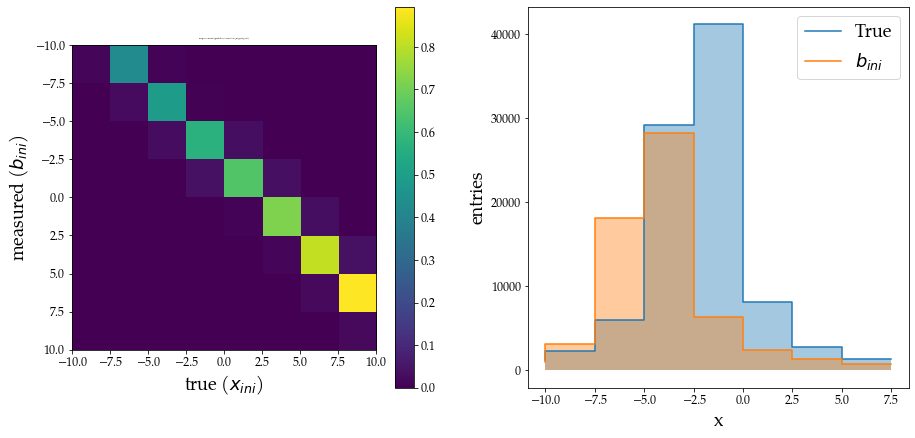

In [16]:
plot_everything(Adetpy, xinipy, binipy, xinipy_edges)

## First try: invert matrix
The resulting histogram will be heavily oscillating due to statistical fluctuations

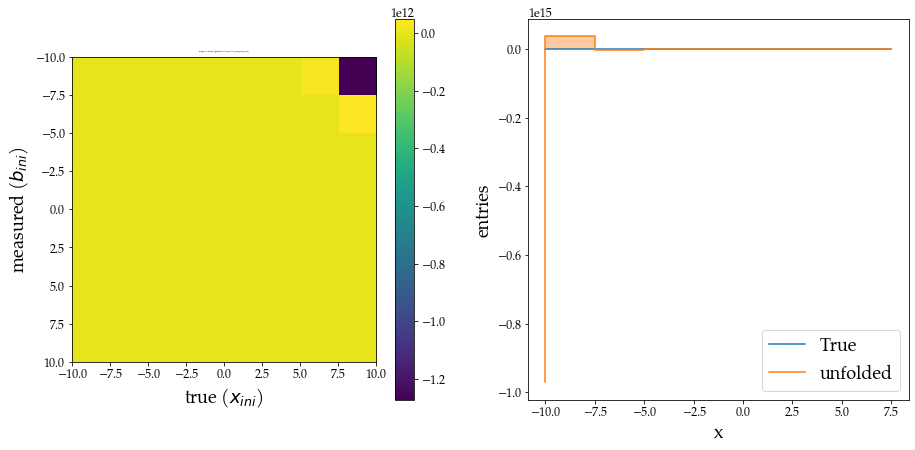

In [20]:
# Invert matrix
Ainv = np.linalg.inv(Adetpy)
# Solve
unfolded = Ainv.dot(binipy)
# Plot
plot_everything(Ainv, xinipy, unfolded, xinipy_edges, reconstructed_name="unfolded")

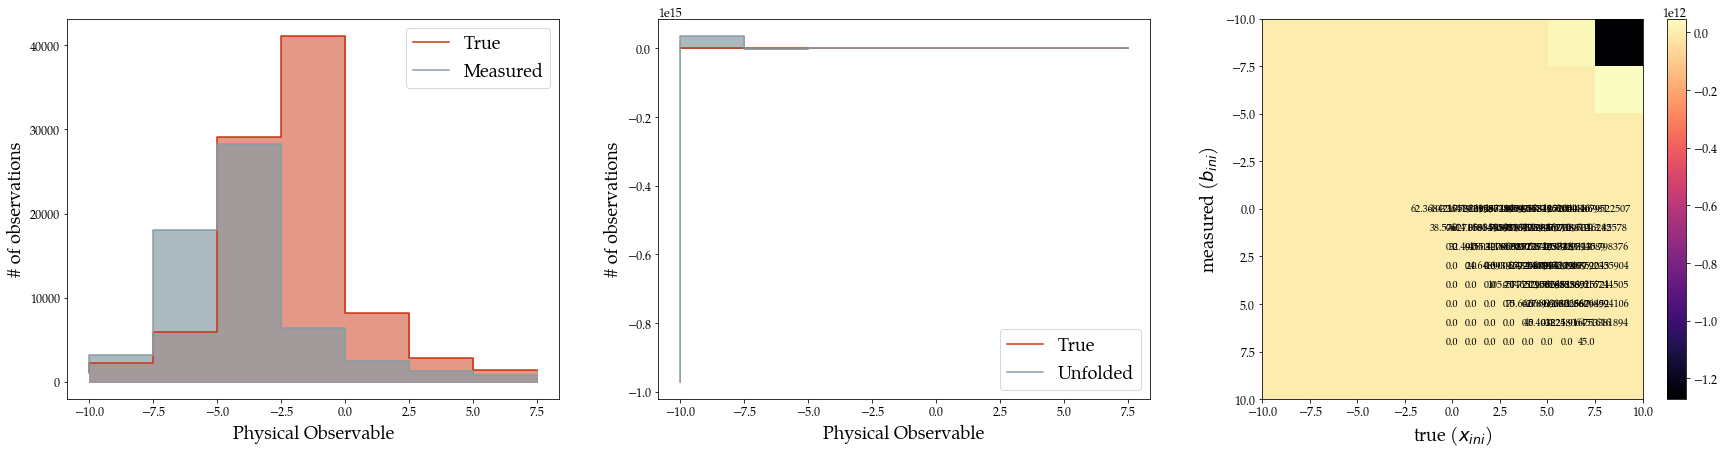

In [33]:
import matplotlib
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['TeX Gyre Pagella']
matplotlib.rcParams['image.cmap'] = 'magma'
plt.rc('axes', titlesize=2)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize

plot_for_document(Ainv, xinipy, binipy, unfolded, xinipy_edges)

In [34]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

fig, ax = plt.subplots()
im, cbar = heatmap(Adetpy, xinipy_edges, binipy_edges, ax=ax,
                   cmap="YlGn", cbarlabel="harvest [t/year]")


ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of ticklabels (1).

## Second try: use a Truncated SVD inversion
Still not working!

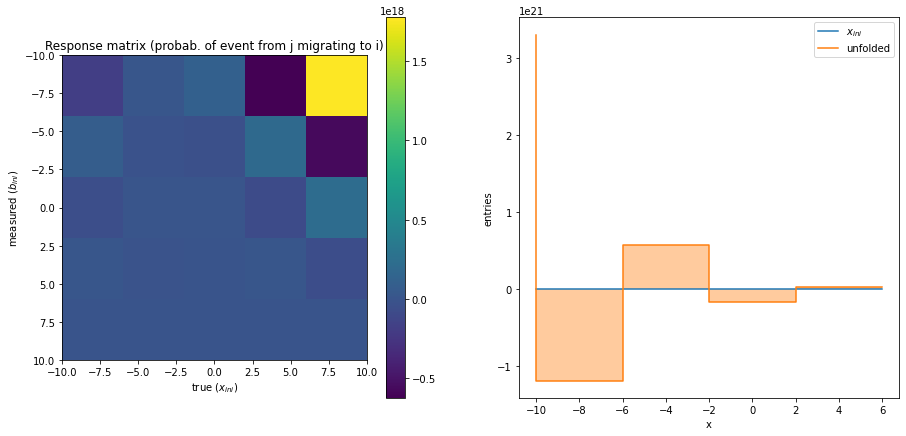

In [11]:
# Pseudo-invert matrix
U, S, Vh = np.linalg.svd(Adetpy, full_matrices=True)
# Truncate (rmax = 5)
r = 3
Apseudo = 0
for i in range(0,r):
    Apseudo += S[i]*np.outer(U[:,i], Vh.T[:,i])
# Invert approximation
Ainv_pseudo = np.linalg.inv(Apseudo)
# Try to unfold
unfolded = Ainv_pseudo.dot(binipy)
# Plot
plot_everything(Ainv_pseudo, xinipy, unfolded, xinipy_edges, reconstructed_name="unfolded")

## Third try: use an SVD inversion but on the inverted matrix!
Still not working!!

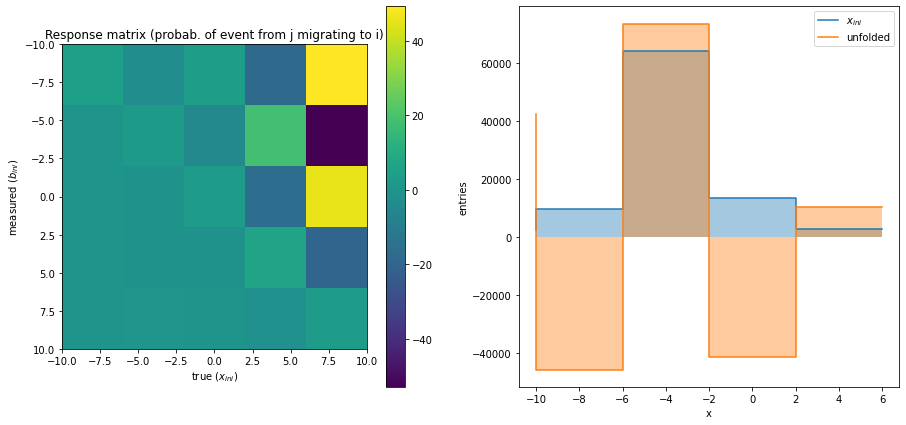

In [88]:
# First invert matrix
Ainv = np.linalg.inv(Adetpy)
# Truncate inversion (rmax = 5)
U, S, Vh = np.linalg.svd(Ainv, full_matrices=True)
r = 3
Ainv_pseudo = 0
for i in range(0,r):
    Ainv_pseudo += S[i]*np.outer(U[:,i], Vh.T[:,i])
# Try to unfold
unfolded = Ainv_pseudo.dot(binipy)
# Plot
plot_everything(Ainv_pseudo, xinipy, unfolded, xinipy_edges, reconstructed_name="unfolded")